Import and declare variables

In [13]:
import subprocess
import os

data_root = "../data"

reference_genome = f"{data_root}/hg19.fasta"
reference_genome_dict = f"{data_root}/hg19.dict"
reference_genome_fai = f"{data_root}/hg19.fai"
input_bam = f"{data_root}/input_reads.bam"
output_vcf = f"{data_root}/output.vcf"
targeted_vcf = f"{data_root}/targeted.vcf"
final_vcf = f"{data_root}/final.vcf"

if not os.path.isfile(reference_genome):
    raise FileNotFoundError("reference genome is missing, add it please")
if not os.path.isfile(input_bam):
    raise FileNotFoundError("patient input bam file is missing, add it please")

In [13]:
if not os.path.isfile(reference_genome_fai):
    subprocess.run([f"samtools faidx {reference_genome}"], shell=True)

Indexing the input bam file

In [14]:
subprocess.run([f"samtools index {input_bam}"], shell=True)

CompletedProcess(args=['samtools index ../data/input_reads.bam'], returncode=0)

Create dict file required for VCF file generation

In [15]:
if not os.path.isfile(reference_genome_dict):
    subprocess.call([f"gatk CreateSequenceDictionary -R {reference_genome} -O {reference_genome_dict}"], shell=True)

In [23]:
subprocess.call([f"gatk HaplotypeCaller -R {reference_genome} -I {input_bam} -O {targeted_vcf} -L ../data/location.bed"], shell=True)

Using GATK jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar HaplotypeCaller -R ../data/hg19.fasta -I ../data/input_reads.bam -O ../data/targeted.vcf -L ../data/location.bed
11:39:03.882 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
11:39:04.102 INFO  HaplotypeCaller - ------------------------------------------------------------
11:39:04.106 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.4.0.0
11:39:04.106 INFO  HaplotypeCaller - For support and documentation go to https://softw

0

Extract targeted positions from VCF

In [9]:
import subprocess
subprocess.call([f"gatk SelectVariants -R {reference_genome} -V {output_vcf} --intervals ../data/location.bed -O ../data/targeted.vcf"], shell=True)

Using GATK jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar SelectVariants -R ../data/hg19.fasta -V ../data/output.vcf --intervals ../data/location.bed -O ../data/targeted.vcf
11:08:55.322 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
11:08:55.476 INFO  SelectVariants - ------------------------------------------------------------
11:08:55.480 INFO  SelectVariants - The Genome Analysis Toolkit (GATK) v4.4.0.0
11:08:55.480 INFO  SelectVariants - For support and documentation go to https://softw

0

Show chromosome spreading

   CHROM       POS ID REF ALT   QUAL FILTER  \
0  chr13  32893180  .  GT   G  110.6      .   
1  chr13  32900363  .  CT   C  433.6      .   
2  chr13  32900440  .  AT   A  192.6      .   
3  chr13  32903565  .  AT   A   44.6      .   
4  chr13  32903635  .  TA   T  290.6      .   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=-0.221;DP=45;E...  GT:AD:DP:GQ:PL   
1  AC=1;AF=0.500;AN=2;BaseQRankSum=-2.315;DP=82;E...  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=-4.074;DP=93;E...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=-1.248;DP=26;E...  GT:AD:DP:GQ:PL   
4  AC=1;AF=0.500;AN=2;BaseQRankSum=-1.726;DP=27;E...  GT:AD:DP:GQ:PL   

                     23_R_119  
0   0/1:38,7:45:99:118,0,1244  
1  0/1:59,23:82:99:441,0,1547  
2  0/1:77,15:92:99:200,0,2209  
3     0/1:22,4:26:52:52,0,611  
4   0/1:11,16:27:99:298,0,296  


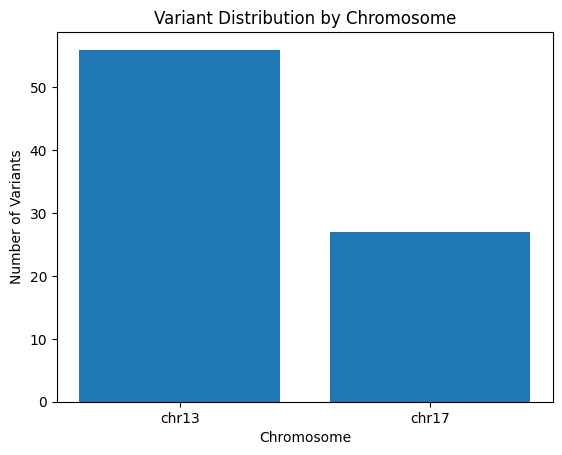

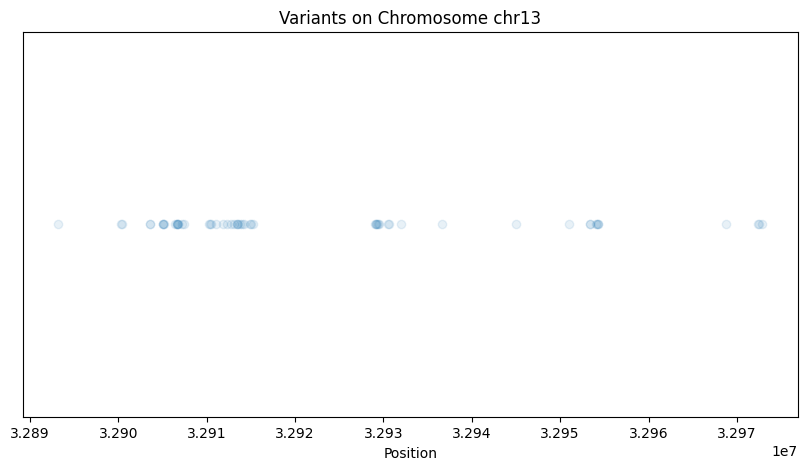

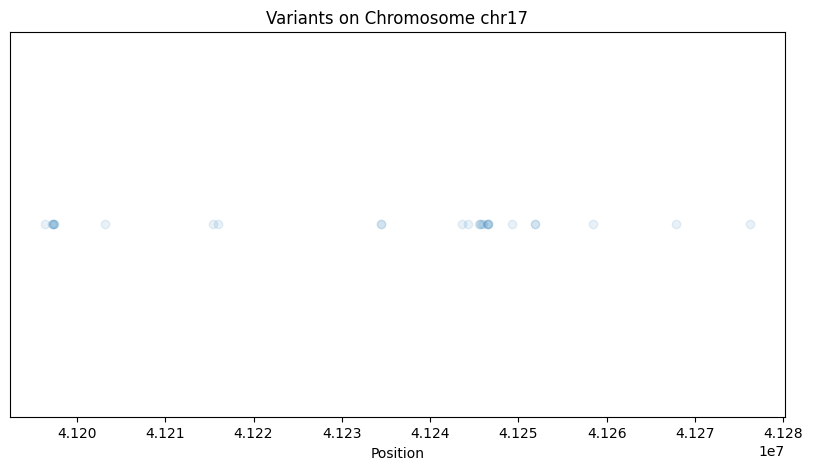

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by chromosome and count the number of variants
# Define the column names
col_names = ['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','23_R_119']

# Load the VCF file
df = pd.read_csv(targeted_vcf, comment='#', sep='\t', names=col_names)

# View the first few rows
print(df.head())

variant_counts = df['CHROM'].value_counts()

# Create a bar plot of the variant counts
plt.bar(variant_counts.index, variant_counts.values)
plt.xlabel('Chromosome')
plt.ylabel('Number of Variants')
plt.title('Variant Distribution by Chromosome')
plt.show()

chromosomes = df['CHROM'].unique()

# For each chromosome
for chrom in chromosomes:
    # Filter the DataFrame for only rows corresponding to this chromosome
    df_chrom = df[df['CHROM'] == chrom]

    # Generate the plot for this chromosome
    plt.figure(figsize=(10, 5))
    plt.scatter(df_chrom['POS'], [1]*len(df_chrom), alpha=0.1)
    plt.yticks([])
    plt.title('Variants on Chromosome {}'.format(chrom))
    plt.xlabel('Position')
    plt.show()

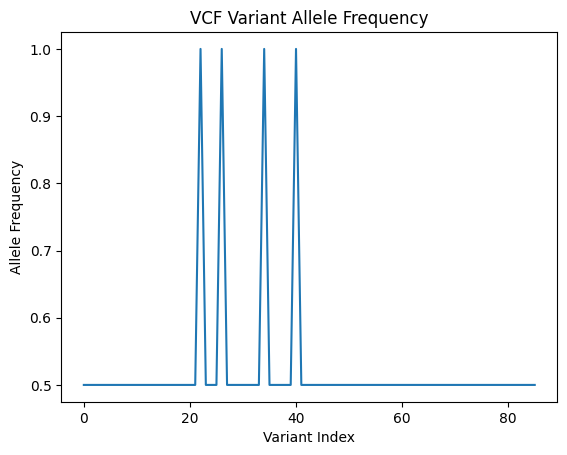

In [11]:
import pysam
import matplotlib.pyplot as plt

vcf_reader = pysam.VariantFile(open(targeted_vcf, "r"))

# Păstrați informațiile relevante pentru grafic (de exemplu, AF - frecvența alelei alternative)
allele_frequencies = []
for record in vcf_reader:
    allele_frequencies.append(record.info.get("AF")[0])

# Plasați graficul
plt.plot(allele_frequencies)
plt.xlabel("Variant Index")
plt.ylabel("Allele Frequency")
plt.title("VCF Variant Allele Frequency")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Lista pentru a stoca calitățile
qualities = []

# Citirea fișierului VCF și extragerea calităților
with open(output_vcf, 'r') as file:
    for line in file:
        if not line.startswith('#'):
            data = line.strip().split('\t')
            quality = float(data[5])
            qualities.append(quality)

# Crearea histogramă a calităților
plt.hist(qualities, bins=20, edgecolor='black')

# Etichetele axelor
plt.xlabel('Quality')
plt.ylabel('Count')

# Titlul diagramei
plt.title('Quality Histogram')

# Afișarea diagramei
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Dicționar pentru a stoca frecvențele alelelor
allele_frequencies = {}

# Citirea fișierului VCF și extragerea informațiilor despre frecvențele alelelor
with open(output_vcf, 'r') as file:
    for line in file:
        if not line.startswith('#'):
            data = line.strip().split('\t')
            info = data[7].split(';')
            for item in info:
                if item.startswith('AF='):
                    freq = item.split('=')[1]
                    if len(item.split(',')) > 1:
                        continue
                    print(freq)
                    allele_frequency = float(freq)
                    allele_frequencies['ALT'] = allele_frequency
                    allele_frequencies['REF'] = 1 - allele_frequency

# Crearea diagramă de tip "pie"
labels = ['Reference (REF)', 'Alternate (ALT)']
sizes = [allele_frequencies['REF'], allele_frequencies['ALT']]
colors = ['#1f77b4', '#ff7f0e']
explode = (0.1, 0)  # Pentru a separa puțin secțiunea "Reference"

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Aspectul circular
plt.axis('equal')

# Titlul diagramei
plt.title('Allele Frequencies')

# Afișarea diagramei
plt.show()
